In [1]:
import matplotlib.pyplot as plt
import mplstereonet as stnt
import numpy as np
import pandas as pd
from pathlib import Path as pth
import sys

sys.path.append(str(pth.cwd().parents[0]))
from utils import *

In [2]:
# Auto KD Tree Facets
fct = pd.read_csv('../Files/Assgn_02/BD_auto_facets.csv', sep=';')
fct.columns = [name.lstrip().lower() for name in fct.columns] # Remove space from column names
fct['strike'] = dip_direction_to_strike(fct['dip dir.']) # Convert dip dir. to strike
fct = fct[fct.surface>0.3].reset_index(drop=True)           # Filter out surfaces < 0.1 m^2
# fct.drop(columns='index', axis=1, inplace=True)
# fct.to_csv('../Files/Assgn_03/BD_auto_facets_filtered_30cm.csv', index=False)

In [3]:
fs3 = pd.read_csv("../Files/Assgn_02/fracture_sets/set_3.txt", sep="\t")
# Extract the index from notes
fs3['Notes'] = fs3['Notes'].apply(lambda x: int(x.split("|")[2]))
# Filter the KD Tree Facets by the index
fs3 = fct[fct['index'].isin(fs3.Notes.to_list())]
fs3["dip dir."].mean(),fs3["dip"].mean()

(218.63235294117646, 38.94117647058823)

### Fracture Set 1 - Slope Stability Analysis
| Property | Angle(˚) |
| :------- | :------: |
| Dip Direction | 232 |
| Dip | 70 |
| Friction angle | 35 |

In [4]:
fs1 = pd.read_csv(
    '../Files/Assgn_03/frac_set_1_subset.txt', sep='\t')
# Remove space from column names
fs1.columns = [name.lstrip().lower() for name in fs1.columns]
fs1['dip'] = 90 - fs1.plunge
fs1['strike'] = fs1['trend'] - 270 # Convert dip dir. to strike
# Slope face direction limits
sdl = pd.DataFrame({'strike': [212,252],'dip': [90,90]}) 
fap = pd.DataFrame({'trend':[0], 'plunge':[90], 'angle':[35]}) # Friction angle poles
sf1 = pd.DataFrame({'strike':[142], 'dip':[70]})           # Slope face plane
# Calculate Daylight plane
pldy = calc_planar_daylight(sf1.strike, sf1.dip)
pl_,td_,ag_ = pldy[0],pldy[1],pldy[2]
dp1 = pd.DataFrame({'trend':[td_], 'plunge':[pl_], 'angle':[ag_]}) 


# Fracture subset within daylight plane and lateral limits
fs1_sub = pd.read_csv(
    '../Files/Assgn_03/frac_set_1_subset_within.txt', sep='\t')
fs1_sub.columns = [name.lstrip().lower() for name in fs1_sub.columns]
fs1_sub['strike'] = fs1_sub['trend'] - 270               # Convert dip dir. to strike
fs1_sub['dip'] = 90 - fs1_sub.plunge
fs1_sub = fs1_sub[['trend','strike','plunge','dip']]

# Fracture subset outside of friction angle and within daylight envelope
fs1_pos_man = pd.read_csv(
    '../Files/Assgn_03/frac_set_1_subset_manual_POF.txt', sep='\t')
fs1_pos_man.columns = [name.lstrip().lower() for name in fs1_pos_man.columns]
fs1_pos_man['strike'] = fs1_pos_man['trend'] - 270        # Convert dip dir. to strike
fs1_pos_man['dip'] = 90 - fs1_pos_man.plunge
fs1_pos_man = fs1_pos_man[['trend','strike','plunge','dip']]

### Plot the Stereonet for Fracture Set delineation

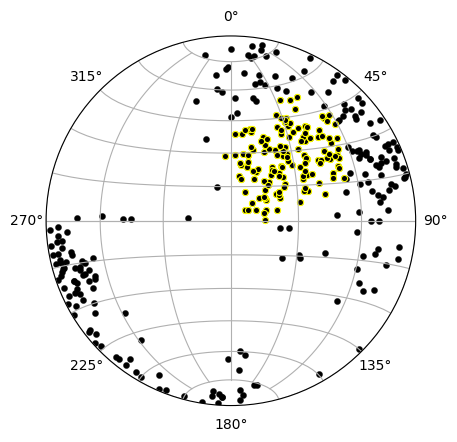

In [5]:
fig, ax = stnt.subplots()
ax.grid()

ax.pole(fct.strike, fct.dip, color='k', s=20, ec='k', marker='o', 
        ls='-',lw=0.2)                                            # Complete Fracture Set
ax.pole(fs1.strike, fs1.dip, color='k', s=20, ec='yellow', marker='o', 
        ls='-',lw=0.8)                                            # Subset Fracture Set
# plt.savefig('../Figures/Assgn_03_separated_poles_in_fs.png', dpi=200, facecolor='white', 
#             edgecolor='none', bbox_inches='tight')
plt.show()

### Plot the Stereonet for manual POF estimates

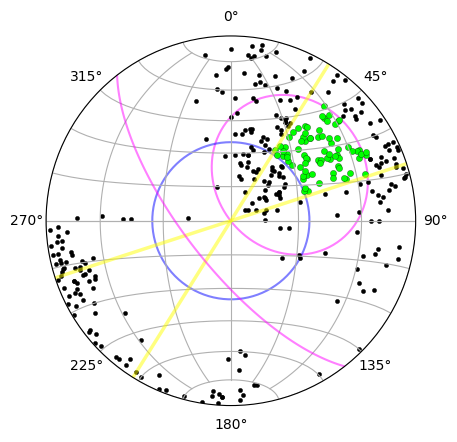

--------------------- Given Set Statistics ---------------------
The probability of failure in the manual case is  54.17%

--------------------- All Sets Statistics  ---------------------
The probability of failure in the manual case is  22.16%


In [6]:
fig, ax = stnt.subplots()
ax.grid()

lw = 1.5

# Define line colors
sdl_col = 'yellow'
slf_col = 'magenta'
fap_col = 'b'

# alpha
aph = 0.5

# Slope Direction limits
ax.plane(sdl.strike, sdl.dip, color=sdl_col, lw=lw+1, alpha=aph)
 # Slope face and daylight plane
ax.plane(sf1.strike, sf1.dip, color=slf_col, lw=lw, alpha=aph)
ax.cone(dp1.plunge, dp1.trend, dp1.angle+0.1, lw=lw, 
        color='None', ec=slf_col, alpha=aph)
# Friction angle poles
ax.cone(fap.plunge, fap.trend, fap.angle, lw=lw, color='None', ec=fap_col, alpha=aph)
ax.pole(fct.strike, fct.dip, color='k', s=10, ec='k', marker='o', 
        ls='-',lw=0.2)                                            # Fracture Set
ax.pole(fs1_pos_man.strike, fs1_pos_man.dip, color='lime', s=20, ec='k', marker='o', 
        ls='-',lw=0.2)                                            # Fracture Set with POF
plt.savefig('../Figures/Assgn_03_manual_POF_in_fs.png', dpi=200, facecolor='white', 
            edgecolor='none', bbox_inches='tight')
plt.show()

# Calculate the probability of failure for each case in this fracture set
pof_man = len(fs1_pos_man) / len(fs1)

print(f"--------------------- Given Set Statistics ---------------------")
print(f"The probability of failure in the manual case is {pof_man*100: .2f}%")

# Calculate the probability of failure for each case for all sets
pof_man = len(fs1_pos_man) / len(fct)
print()
print(f"--------------------- All Sets Statistics  ---------------------")
print(f"The probability of failure in the manual case is {pof_man*100: .2f}%")

### Calculate Probability of Failure
Use poles for all fractures within daylight envelope and fracture lateral limits <br>
Factor of Safety (FS):
$$
FS = \frac {c_0A + (Wcos\theta - \alpha Wsin\theta + bsin\theta - pA) tan\phi_j} {Wsin\theta - \alpha Wcos\theta -bcos\theta}
$$
where

In [7]:
phi = 35     # Joint Friction angle (deg)
p = 0.05     # Water Pressure (MPa)
c0 = 0.04    # Joint Cohesion (MPa)
w = 25       # Block Weight (MN)
a = 100      # Joint surface area (m^2)
ah = 0       # Seismic Coefficient
bt = 0       # Total bolt force (MN)

def calc_factor_of_safety(c0,w,a,dip,phi, p, ah, bt):
    num = (c0*a) + ((w * np.cos(np.radians(dip))) - 
                    (ah * w * np.sin(np.radians(dip))) - 
                    (bt * np.sin(np.radians(dip))) - 
                    (p * a)) * np.tan(np.radians(phi))
    den = ((w * np.sin(np.radians(dip))) - 
            (ah * w * np.cos(np.radians(dip))) - (
                bt * np.cos(np.radians(dip))))
    fs = num/den
    return np.around(fs, 2)

fs_dry = calc_factor_of_safety(c0=0,p=0,w=w,a=a,dip=fs1_sub.dip, phi=phi,ah=0,bt=0)
fs_sat = calc_factor_of_safety(c0=0,p=p,w=w,a=a,dip=fs1_sub.dip, phi=phi,ah=0,bt=0)
fs_wat_coh = calc_factor_of_safety(c0=c0,p=p,w=w,a=a,dip=fs1_sub.dip, phi=phi,ah=0,bt=0)


# Define the factor of safety for dry and saturated cases
fs1_sub['FS_dry'] = fs_dry
fs1_sub['FS_sat'] = fs_sat
fs1_sub['FS_wat_coh'] = fs_wat_coh

# If it's greater than zero, POF is zero. If less, it is 1
fs1_sub['Failure_dry'] = np.where(fs_dry>1,0,1)
fs1_sub['Failure_sat'] = np.where(fs_sat>1,0,1)
fs1_sub['Failure_wat_coh'] = np.where(fs_wat_coh>1,0,1)

# Calculate the probability of failure for each case in this fracture set
pof_dry = fs1_sub['Failure_dry'].sum() / len(fs1)
pof_sat = fs1_sub['Failure_sat'].sum() / len(fs1)
pof_wat_coh = fs1_sub['Failure_wat_coh'].sum() / len(fs1)

print(f"--------------------- Given Set Statistics ---------------------")
print(f"The probability of failure in the dry case is \t\t\t {pof_dry*100: .2f}%")
print(f"The probability of failure in the saturated case is \t\t {pof_sat*100: .2f}%")
print(f"The probability of failure in the water and cohesion case is \t {pof_wat_coh*100: .2f}%")


# Calculate the probability of failure for each case for all sets
pof_dry = fs1_sub['Failure_dry'].sum() / len(fct)
pof_sat = fs1_sub['Failure_sat'].sum() / len(fct)
pof_wat_coh = fs1_sub['Failure_wat_coh'].sum() / len(fct)

print()
print(f"--------------------- All Sets Statistics  ---------------------")
print(f"The probability of failure in the dry case is \t\t\t {pof_dry*100: .2f}%")
print(f"The probability of failure in the saturated case is \t\t {pof_sat*100: .2f}%")
print(f"The probability of failure in the water and cohesion case is \t {pof_wat_coh*100: .2f}%")

--------------------- Given Set Statistics ---------------------
The probability of failure in the dry case is 			  54.17%
The probability of failure in the saturated case is 		  60.42%
The probability of failure in the water and cohesion case is 	  53.47%

--------------------- All Sets Statistics  ---------------------
The probability of failure in the dry case is 			  22.16%
The probability of failure in the saturated case is 		  24.72%
The probability of failure in the water and cohesion case is 	  21.88%


### Plot the stereonet for stability analysis

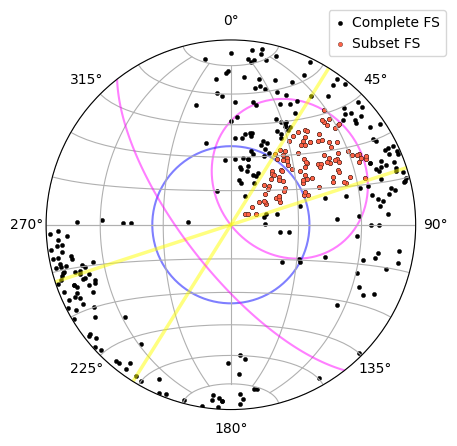

In [8]:
fig, ax = stnt.subplots()
ax.grid()

lw = 1.5

# Define line colors
sdl_col = 'yellow'
slf_col = 'magenta'
fap_col = 'b'

# alpha
aph = 0.5

ax.plane(sdl.strike, sdl.dip, color=sdl_col, lw=lw+1, alpha=aph)                     # Slope Direction limits
ax.plane(sf1.strike, sf1.dip, color=slf_col, lw=lw, alpha=aph)                       # Slope face and daylight plane
ax.cone(dp1.plunge, dp1.trend, dp1.angle+0.1, lw=lw, color='None', ec=slf_col, alpha=aph)
ax.cone(fap.plunge, fap.trend, fap.angle, lw=lw, color='None', ec=fap_col, alpha=aph)# Friction angle poles
ax.pole(fct.strike, fct.dip, color='k', s=10, ec='k', marker='o', 
        ls='-',lw=0.2, label='Complete FS')                                          # Complete Fracture Set
ax.pole(fs1_sub.strike, fs1_sub.dip, color='tomato', s=10, ec='k', marker='o', 
        ls='-',lw=0.2, label='Subset FS')                                            # Subset Fracture Set
ax.legend(bbox_to_anchor=(1.1,1.1),handletextpad=0.5,handlelength=0.8,markerscale=1)
plt.savefig('../Figures/Assgn_03_plane_failure_stereonet.png', dpi=200, facecolor='white', 
            edgecolor='none', bbox_inches='tight')
plt.show()

In [9]:
# fs1_sub.drop(columns='strike', inplace=True)
# fs1_sub.to_csv('../Files/Assgn_03/Slope_failure_calculations.csv', index=False)